---
title: Multislice Algorithm
authors: [gvarnavides]
date: 2025-01-23
---

In [19]:
%matplotlib widget
import py4DSTEM
import abtem
import ase

import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

abtem.config.set({"dask.lazy":False});

## Relativistic Wavelength

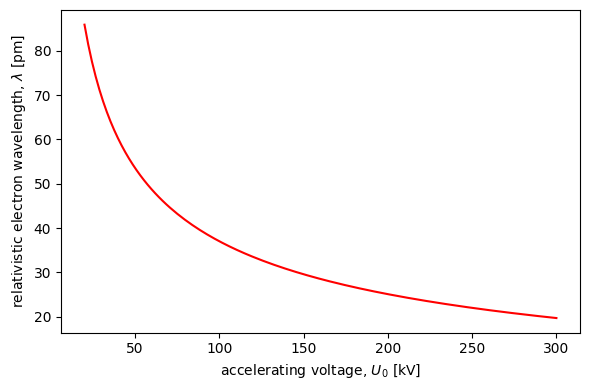

In [20]:
#| label: app:relativistic_wavelength
energies = np.linspace(20e3,300e3,128)
wavelengths = abtem.core.units.energy2wavelength(energies)

with plt.ioff():
    fig,ax = plt.subplots(figsize=(6,4))
ax.plot(energies/1e3,wavelengths*1e3,color='red')
ax.set(
    xlabel=r"accelerating voltage, $U_0$ [kV]",
    ylabel=r"relativistic electron wavelength, $\lambda$ [pm]"
)
fig.tight_layout()
fig

## Interactive Multislice

In [21]:
Si3N4_crystal = ase.Atoms(
    "Si6N8",
    scaled_positions=[
        (0.82495, 0.59387, 0.75),
        (0.23108, 0.82495, 0.25),
        (0.59387, 0.76892, 0.25),
        (0.40614, 0.23108, 0.75),
        (0.76892, 0.17505, 0.75),
        (0.17505, 0.40613, 0.25),
        
        (0.66667, 0.33334, 0.75),
        (0.33334, 0.66667, 0.25),
        (0.66986, 0.70066, 0.75),
        (0.96920, 0.66986, 0.25),
        (0.70066, 0.03081, 0.25),
        (0.29934, 0.96919, 0.75),
        (0.33015, 0.29934, 0.25),
        (0.03081, 0.33014, 0.75),
    ],
    cell=[7.6045, 7.6045, 2.9052, 90, 90, 120],
    pbc=True
)

Si3N4_orthorhombic = abtem.orthogonalize_cell(Si3N4_crystal)
Si3N4_orthorhombic *= (3,2,17)

In [22]:
potential = abtem.Potential(
    Si3N4_orthorhombic,
    sampling = 0.1,
    slice_thickness = Si3N4_orthorhombic.cell[2,2]/32,
    parametrization = 'lobato',
    projection = 'finite',
).build(
)

In [23]:
probe = abtem.Probe(
    semiangle_cutoff=20,
    energy=300e3,
    defocus=100,
)
probe.match_grid(potential)

In [24]:
slices = potential.generate_slices()
prop = abtem.multislice.FresnelPropagator()

track_arrays = [
    None, # positions_px
    None, # slice
    None, # waves
    None, # zy view
    None, # index,
    None, # slices generator
]

track_arrays[0] = np.array(potential.gpts)/2
positions = track_arrays[0] * np.array(potential.sampling)
track_arrays[2] = probe.build(positions)
track_arrays[3] = np.zeros((potential.num_slices,potential.gpts[1]),dtype=np.complex64)
track_arrays[3][0] = track_arrays[2].array.sum(0)
track_arrays[4] = 0
track_arrays[5] = slices

In [25]:
def unshift_waves(waves, positions_px):
    shifted_waves = waves.copy()
    shifted_waves._array = abtem.core.fft.fft_shift(
        shifted_waves.array,
        -positions_px
    )
    return shifted_waves

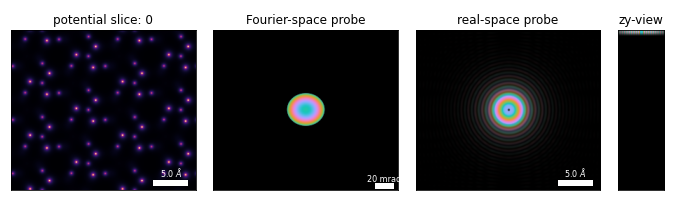

In [26]:
dpi = 72
with plt.ioff():
    fig = plt.figure(figsize=(675/dpi, 220/dpi),dpi=dpi)

spec = GridSpec(
    nrows=1,
    ncols=4,
    width_ratios=[4,4,4,1],
)

ax0=fig.add_subplot(spec[0])
bar_common = {"Nx":potential.gpts[0],"Ny":potential.gpts[1],"labelsize":8}
im_pot = ax0.imshow(potential.array[0],vmin=0,vmax=600,cmap='magma')
bar_pot = bar_common | {"pixelsize":potential.sampling[1],"pixelunits":r"$\AA$"}

ax1=fig.add_subplot(spec[1])
shifted_probe = unshift_waves(track_arrays[2],track_arrays[0])
rgb_fourier_probe = py4DSTEM.visualize.Complex2RGB(
    shifted_probe.diffraction_patterns(
        max_angle=None,
        return_complex=True
    ).array,
)
im_fourier = ax1.imshow(rgb_fourier_probe)
bar_fourier= bar_common | {"pixelsize":probe.angular_sampling[1],"pixelunits":"mrad"}

ax2=fig.add_subplot(spec[2])
rgb_complex_probe = py4DSTEM.visualize.Complex2RGB(
    track_arrays[2].array
)
im_complex = ax2.imshow(rgb_complex_probe)
bar_complex= bar_common | {"pixelsize":probe.sampling[1],"pixelunits":r"$\AA$"}

ax3=fig.add_subplot(spec[3])
rgb_zy_probe = py4DSTEM.visualize.Complex2RGB(
    track_arrays[3]
)
im_zy = ax3.imshow(rgb_zy_probe,aspect=potential.gpts[0]/potential.num_slices*4)
ax3.set(xticks=[],yticks=[],title="zy-view")

axs = [ax0,ax1,ax2]
bars = [bar_pot, bar_fourier, bar_complex]
titles= ["potential slice: 0", "Fourier-space probe", "real-space probe"]

for ax, bar, title in zip(axs, bars, titles):
    ax.set(xticks=[],yticks=[],title=title)
    # divider = make_axes_locatable(ax)
    # ax_cb = divider.append_axes("right", size="5%", pad="2.5%")
    # py4DSTEM.visualize.add_colorbar_arg(ax_cb)
    py4DSTEM.visualize.add_scalebar(ax,bar)

fig.canvas.resizable = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.toolbar_visible = True
fig.canvas.layout.width = '675px'
fig.canvas.layout.height = '240px'
fig.canvas.toolbar_position = 'bottom'
spec.tight_layout(fig)
fig.canvas

In [27]:
transmit_button = ipywidgets.Button(description='transmit',button_style='warning')
propagate_button = ipywidgets.Button(description='propagate',disabled=True)
reset_button = ipywidgets.Button(description="reset")

def toggle_button_visibility(button):
    if button.disabled:
        button.button_style="warning"
        button.disabled = False
    else:
        button.button_style=""
        button.disabled = True
    return None

def update_probes(zy_view=False):
    waves = track_arrays[2]
    
    shifted_probe = unshift_waves(waves,track_arrays[0])
    rgb_fourier_probe = py4DSTEM.visualize.Complex2RGB(
        shifted_probe.diffraction_patterns(
            max_angle=None,
            return_complex=True
        ).array,
    )
    im_fourier.set_data(rgb_fourier_probe)

    rgb_complex_probe = py4DSTEM.visualize.Complex2RGB(
        waves.array
    )
    im_complex.set_data(rgb_complex_probe)

    if zy_view:
        rgb_zy_probe = py4DSTEM.visualize.Complex2RGB(
            track_arrays[3]
        )
        im_zy.set_data(rgb_zy_probe)
        
    fig.canvas.draw_idle()
    return None
    
def transmit():
    try:
        track_arrays[1] = next(track_arrays[5])
    except:
        return None
    t, waves = track_arrays[1:3]
    t.transmit(waves)

    # update plots
    im_pot.set_data(t.array[0])
    ax0.set_title(f"potential slice: {track_arrays[4]}")
    update_probes(zy_view=False)
    return None

def propagate():
    if track_arrays[4] > potential.num_slices - 1:
        return None
    prop.propagate(track_arrays[2],track_arrays[1].thickness,in_place=True)
    # update plots
    track_arrays[3][track_arrays[4]] = track_arrays[2].array.sum(0)
    update_probes(zy_view=True)
    track_arrays[4] += 1
    return None

def transmit_callback(*args):
    transmit()
    toggle_button_visibility(transmit_button)
    toggle_button_visibility(propagate_button)
    return None

def propagate_callback(*args):
    propagate()
    toggle_button_visibility(transmit_button)
    toggle_button_visibility(propagate_button)
    return None

def reset_callback(*args,reset_positions = True):

    if reset_positions:
        track_arrays[0] = np.array(potential.gpts)/2
        
    positions = track_arrays[0] * np.array(potential.sampling)
    track_arrays[2] = probe.build(positions)
    track_arrays[3] = np.zeros((potential.num_slices,potential.gpts[1]),dtype=np.complex64)
    track_arrays[3][0] = track_arrays[2].array.sum(0)
    track_arrays[4] = 0
    track_arrays[5] = potential.generate_slices()
    
    im_pot.set_data(potential.array[0])
    ax0.set_title(f"potential slice: {track_arrays[4]}")
    update_probes(zy_view=True)
    return None

transmit_button.on_click(transmit_callback)
propagate_button.on_click(propagate_callback)
reset_button.on_click(reset_callback)

def onclick(event):
    """ """
    positions_px = np.array([event.ydata,event.xdata])
    
    if positions_px[0] is not None:
        track_arrays[0] = positions_px
        reset_callback(reset_positions=False)

cid = fig.canvas.mpl_connect('button_press_event',onclick)

def on_value_change(change):
    play.value = track_arrays[4]
    transmit()
    propagate()
    return None
    
play = ipywidgets.Play(
    value=0,
    min=0,
    max=potential.num_slices-1,
    step=1,
)

slider = ipywidgets.IntSlider(min=0, max=potential.num_slices-1, step=1)

ipywidgets.jslink((play, 'value'), (slider, 'value'))
slider.observe(on_value_change, 'value')

In [28]:
#| label: app:multislice_widget

ipywidgets.VBox(
    [
        ipywidgets.HBox([transmit_button,propagate_button,reset_button,play]),
        fig.canvas
    ],
    layout=ipywidgets.Layout(
        align_items="center"
    )
)